In [228]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 그림을 로딩없이 바로 볼 수 있게 하는 명령어
%matplotlib inline
# 한글 폰트 사용 시 글자를 선명하게 하는 명령어
%config InlineBackend.figure_format = 'retina'


## 포켓몬 데이터 불러오기

In [229]:
# 환경변수 설정
users_dir = os.getenv("PYTHON-TRAINING", "/default/path")
# 절대 경로 설정
csv_path = "/Users/mac/Documents/GitHub/python-training/notebooks/Pokemon.csv"
# 원본 데이터를 담은 변수는 고이 놔두는 습관 필요
original_data = pd.read_csv(csv_path)
# 데이터를 카피해서 사용
pokemon = original_data.copy()


In [230]:
# 전설의 포켓몬 데이터셋 생성
legendary = pokemon[pokemon["Legendary"] == True].reset_index(drop=True)
display(legendary.shape)
display(legendary.head())

(65, 13)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True


In [231]:
# 일반 포켓몬 데이터셋 생성
ordinary = pokemon[pokemon["Legendary"] == False].reset_index(drop=True)
display(ordinary.shape)
display(ordinary.head())

(735, 13)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [232]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [233]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


## 결측치와 전체 칼럼
데이터셋 하나하나 뜯어보기

### 범주형
* Name : 포켓몬 이름. 포켓몬 각각의 이름으로 저장되고, 800개의 포켓몬의 이름 데이터는 모두 다름
* Type 1: 첫 번째 속성, 속성을 하나만 가지는 경우 Type 1에 입력
* Type 2: 두 번째 속성, 속성을 하나만 가지는 포켓몬의 경우 Type2는 NaN을 가짐

### 숫자형
* '#' : 포켓만 ID number 성별은 다르지만 같은 포켓몬인 경우 등은 같은 #을 가짐
* Total: 전체 6가지 스탯의 총합
* HP: 포켓몬의 체력
* Attack: 물리 공격력
* Defense: 물리 공격에 대한 방어력
* Sp.Atk: 특수 공격력
* Sp.Def: 특수 공격에 대한 방어력
* Speed: 포켓몬 매치에 대해 어떤 포켓몬이 먼저 공격할지 결정 (더 높은 포켓몬이 먼저 공격)
* Generation: 포켓몬의 세대. 현대 6세대까지 있음
* Legendary: 전설의 포켓몬 여부 (bool)

In [234]:
# 빈 데이터 확인하기 - 결측치 확인
pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [235]:
# 전체 columns 출력해서 이해해보기
cols = pokemon.columns
display(cols)
display(len(cols))

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

13

In [236]:
# 전체 rows 출력해서 이해해보기
for col in pokemon.columns:
    print(f"{col} : {pokemon[col].nunique()} , {pokemon[col].unique()}")

# : 721 , [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 

In [237]:
# id_num 중복값 갯수 확인
id_num = pokemon.duplicated(subset='#', keep='first')
print(sum(id_num)) # True 갯수 확인
print(sum(~id_num)) # False 갯수 확인

# id_num 중복값 고유 이름 확인
duplicate_id_num = pokemon.loc[pokemon.duplicated(subset='#', keep='first'), 'Name']
print(duplicate_id_num.unique())

# 중복값 고유 이름 포함 데이터프레임 출력
duplicate_rows = pokemon[pokemon.duplicated(subset='#', keep='first')]
display(duplicate_rows[cols]) 

79
721
['VenusaurMega Venusaur' 'CharizardMega Charizard X'
 'CharizardMega Charizard Y' 'BlastoiseMega Blastoise'
 'BeedrillMega Beedrill' 'PidgeotMega Pidgeot' 'AlakazamMega Alakazam'
 'SlowbroMega Slowbro' 'GengarMega Gengar' 'KangaskhanMega Kangaskhan'
 'PinsirMega Pinsir' 'GyaradosMega Gyarados' 'AerodactylMega Aerodactyl'
 'MewtwoMega Mewtwo X' 'MewtwoMega Mewtwo Y' 'AmpharosMega Ampharos'
 'SteelixMega Steelix' 'ScizorMega Scizor' 'HeracrossMega Heracross'
 'HoundoomMega Houndoom' 'TyranitarMega Tyranitar' 'SceptileMega Sceptile'
 'BlazikenMega Blaziken' 'SwampertMega Swampert' 'GardevoirMega Gardevoir'
 'SableyeMega Sableye' 'MawileMega Mawile' 'AggronMega Aggron'
 'MedichamMega Medicham' 'ManectricMega Manectric' 'SharpedoMega Sharpedo'
 'CameruptMega Camerupt' 'AltariaMega Altaria' 'BanetteMega Banette'
 'AbsolMega Absol' 'GlalieMega Glalie' 'SalamenceMega Salamence'
 'MetagrossMega Metagross' 'LatiasMega Latias' 'LatiosMega Latios'
 'KyogrePrimal Kyogre' 'GroudonPrimal Groud

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
12,9,BlastoiseMega Blastoise,Water,NaN,630,79,103,120,135,115,78,1,False
19,15,BeedrillMega Beedrill,Bug,Poison,495,65,150,40,15,80,145,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,711,GourgeistSmall Size,Ghost,Grass,494,55,85,122,58,75,99,6,False
786,711,GourgeistLarge Size,Ghost,Grass,494,75,95,122,58,75,69,6,False
787,711,GourgeistSuper Size,Ghost,Grass,494,85,100,122,58,75,54,6,False
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True


## ID와 이름 살펴보기

In [238]:
# ID number 갯수 확인
# set는 중복 허용 안됨
display(len(set(pokemon['#'])))

# ID number가 6인 포켓몬 확인
display(pokemon[pokemon["#"] == 6])

721

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


In [239]:
# Name 갯수 확인
len(set(pokemon['Name']))

800

## 결측치 파악

In [240]:
# Type 1 & Type 2 : 포켓몬 속성
pokemon.loc[[6, 10]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
10,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False


In [241]:
# 속성 갯수 확인
len(list(set(pokemon["Type 1"]))), len(list(set(pokemon["Type 2"]))) 

(18, 19)

In [242]:
# 파이썬 차집합 함수(set difference)
set(pokemon["Type 2"]) - set(pokemon["Type 1"])

{nan}

In [243]:
types = list(set(pokemon["Type 1"]))
display(types)
display(len(types))

['Fire',
 'Normal',
 'Fairy',
 'Fighting',
 'Dragon',
 'Flying',
 'Ground',
 'Ghost',
 'Grass',
 'Ice',
 'Electric',
 'Steel',
 'Dark',
 'Bug',
 'Water',
 'Psychic',
 'Poison',
 'Rock']

18

In [244]:
# 결측치 확인
# 속성 1만 가지고 있는 포켓몬 갯수 확인
pokemon["Type 2"].isna().sum()

np.int64(386)

## 데이터셋 시각화

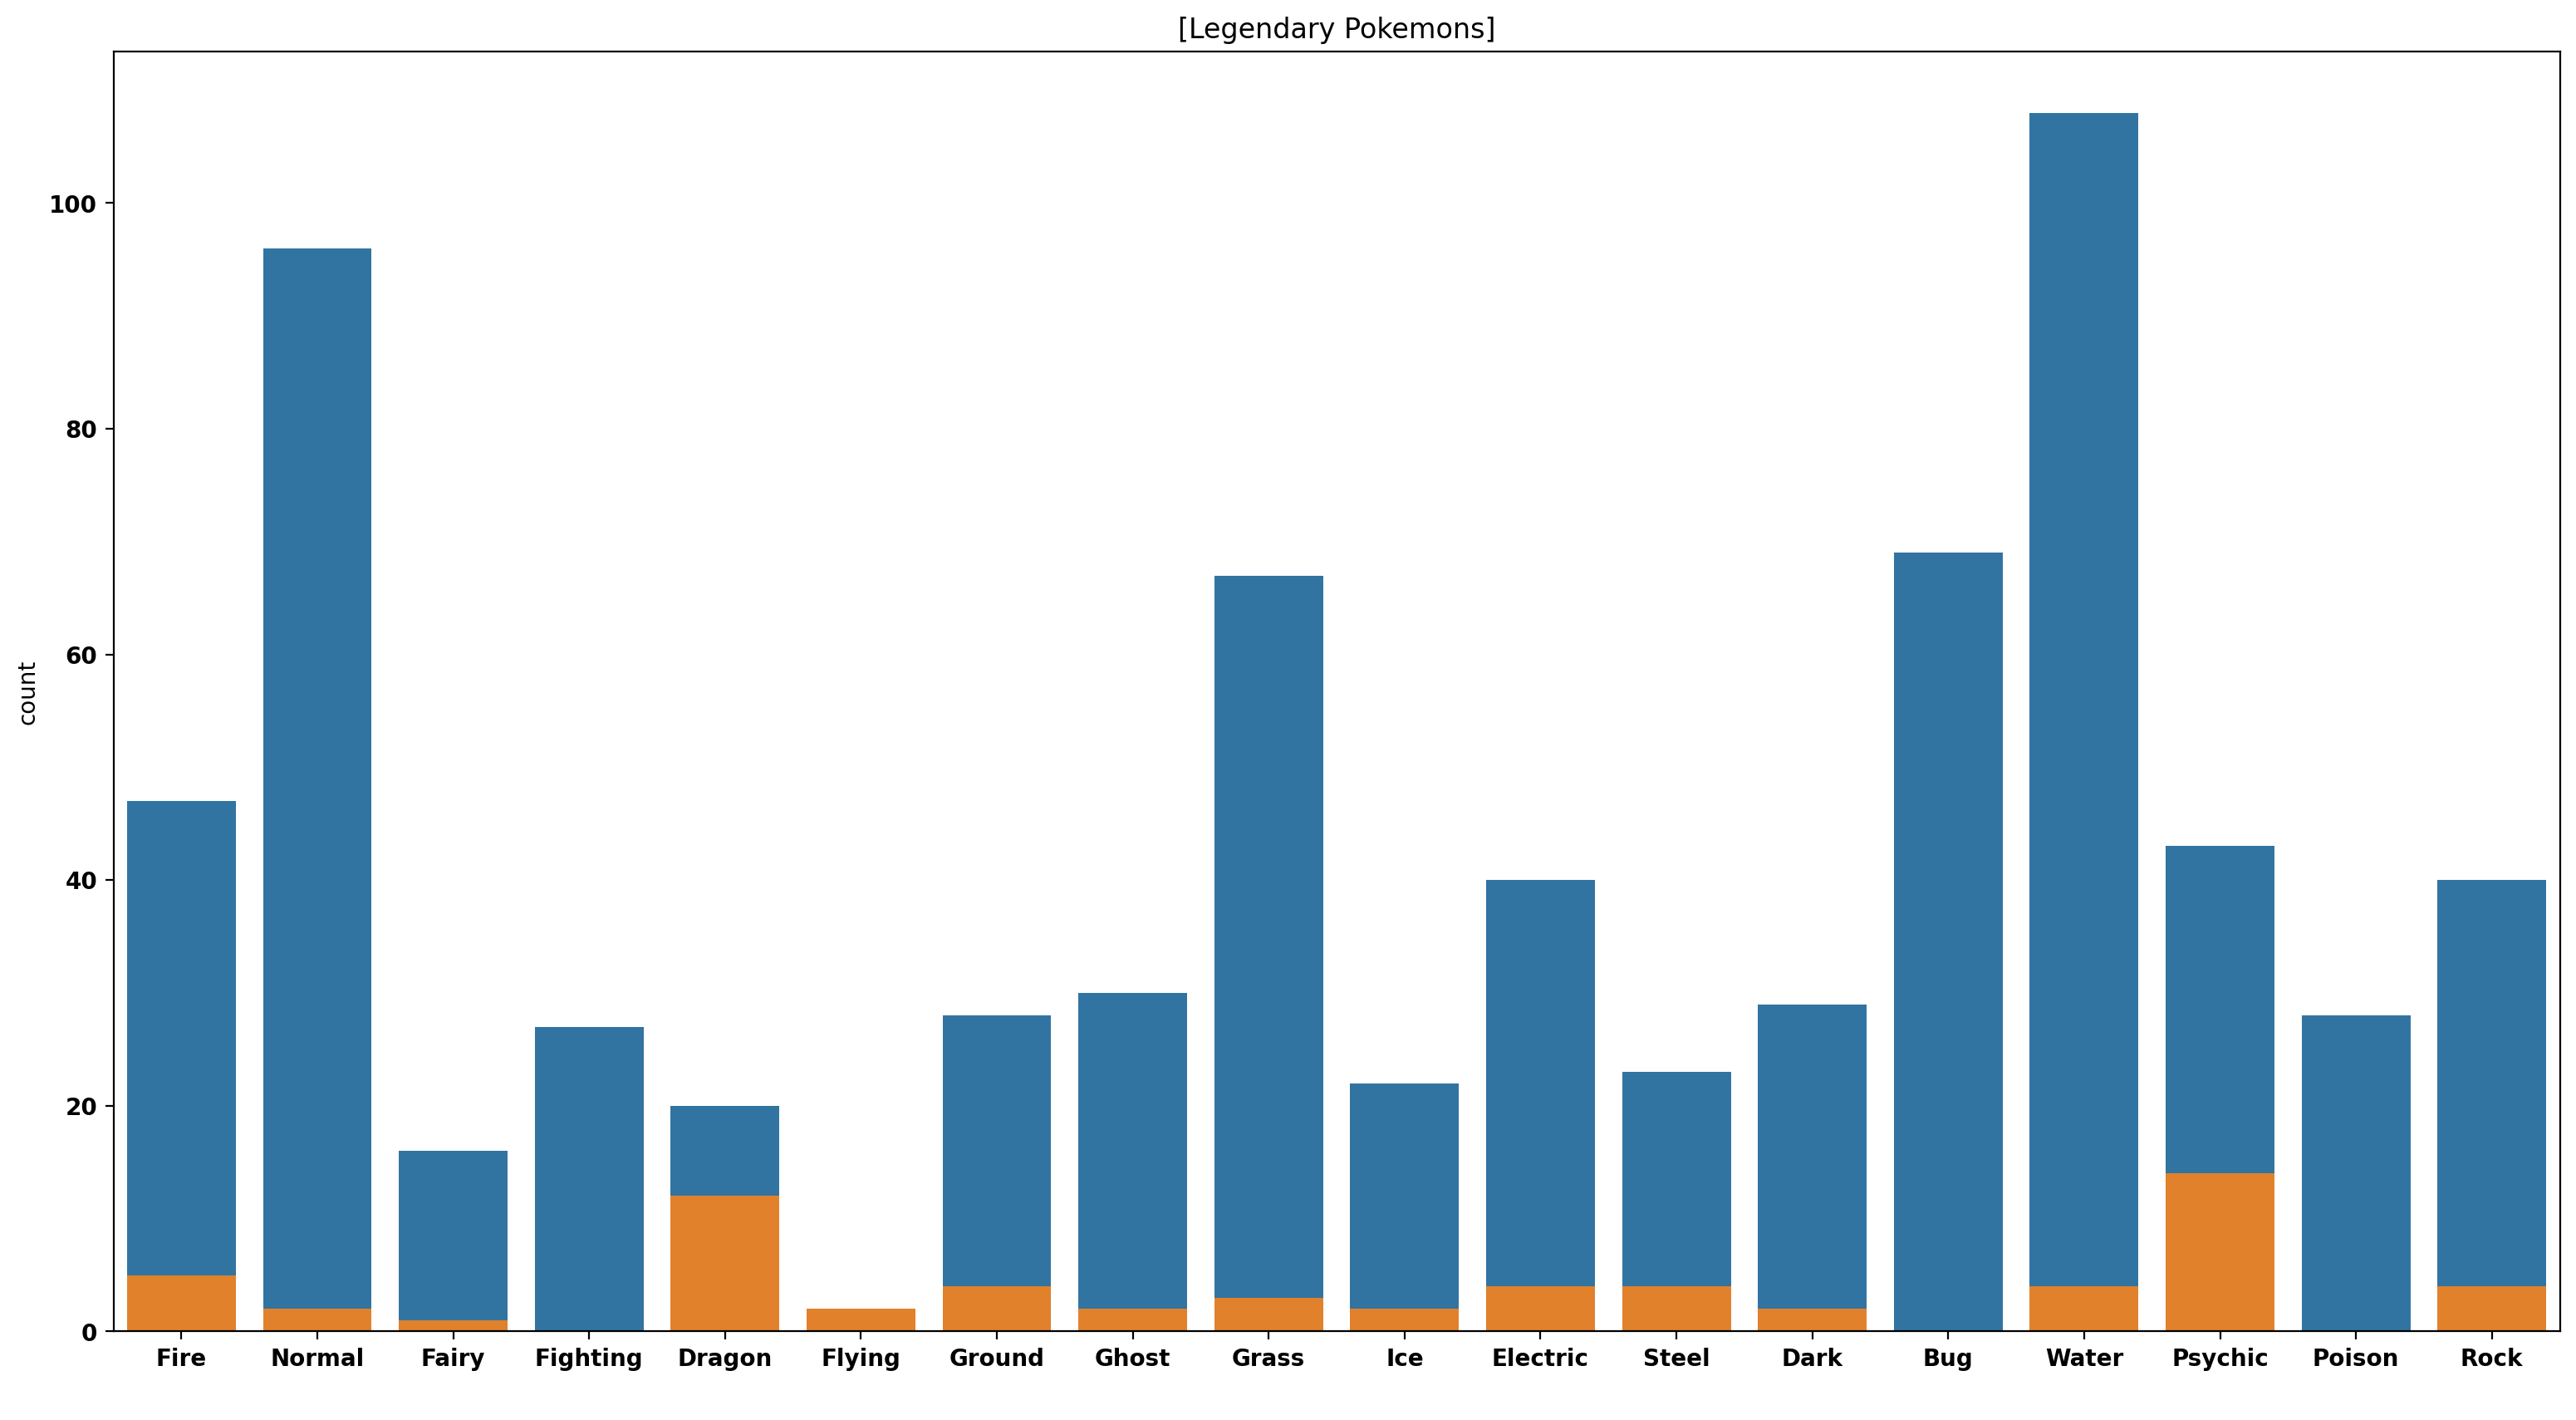

In [245]:
# 데이터 불균형일 때 시각화 -> 전설의 포켓몬 데이터에 대한 정보가 누락될 가능성이 있기 때문에
plt.figure(figsize=(19,10))

sns.countplot(data=ordinary, x="Type 1", order=types).set_xlabel(' ')
plt.title("[Ordinary Pokemons]")

sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel(' ')
plt.title("[Legendary Pokemons]")
plt.rc('font', size=10, weight="bold")

plt.show()

In [246]:
# 피벗 테이블로 Legendary 포켓몬 퍼센트 확인
# Type1별로 Legendary의 비율을 보여주는 pivot table
pd.pivot_table(pokemon, index="Type 1", values="Legendary").sort_values(by=["Legendary"], ascending=False) * 100

,Legendary
Type 1,
Flying,50.000000
Dragon,37.500000
Psychic,24.561404
Steel,14.814815
Ground,12.500000
Fire,9.615385
Electric,9.090909
Rock,9.090909
Ice,8.333333


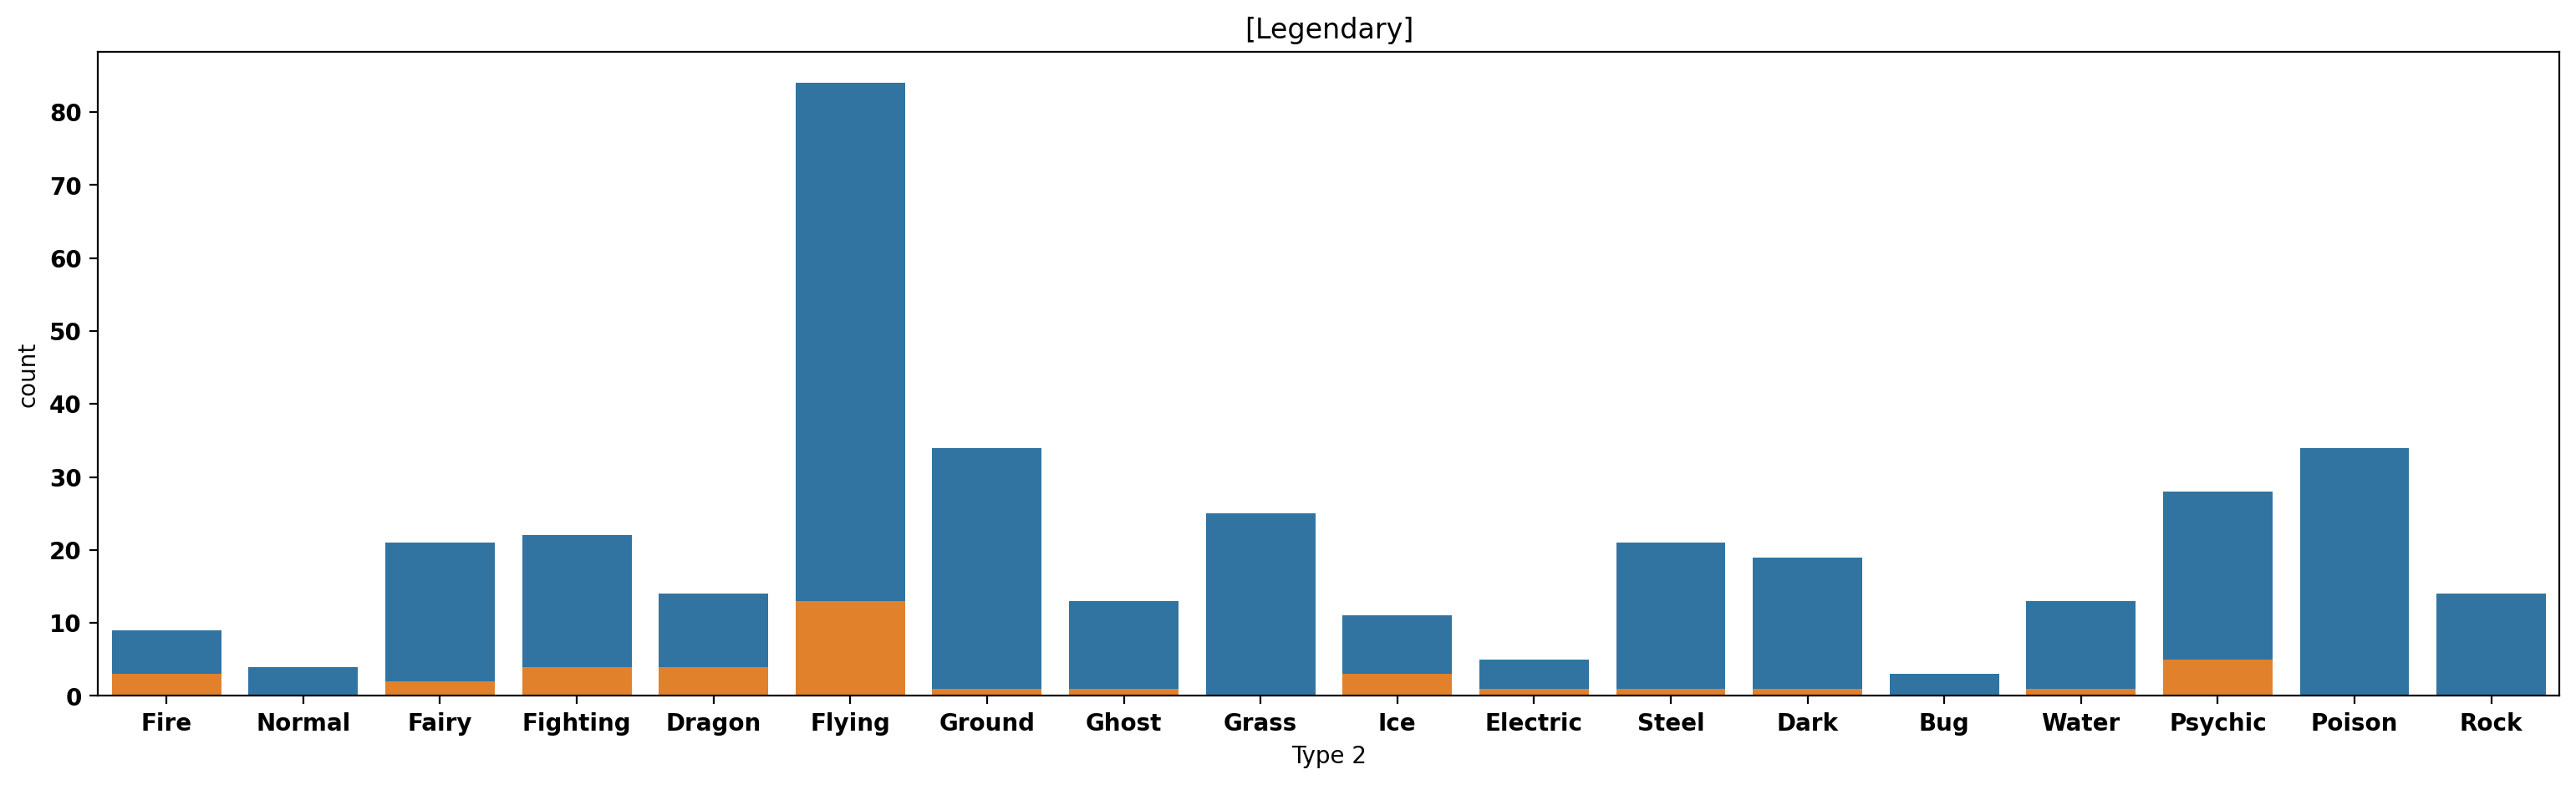

In [247]:
# Type 2 데이터 분포 plot
# Countplot의 경우 결측값은 자동으로 제외

plt.figure(figsize=(19, 5))

sns.countplot(data=ordinary, x="Type 2", order=types).set_label('')
plt.title("[Ordinary Pokemons]")

sns.countplot(data=legendary, x="Type 2", order=types).set_label('')
plt.title("[Legendary]")

plt.show()

In [248]:
# 피벗 테이블로 Legendary 포켓몬 퍼센트 확인
# Type2별로 Legendary의 비율을 보여주는 pivot table

pd.pivot_table(pokemon, index="Type 2", values="Legendary").sort_values(by=["Legendary"], ascending=False) * 100

,Legendary
Type 2,
Fire,25.000000
Dragon,22.222222
Ice,21.428571
Electric,16.666667
Fighting,15.384615
Psychic,15.151515
Flying,13.402062
Fairy,8.695652
Water,7.142857


In [249]:
# 모든 스탯 종류 저장
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
stats

['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

In [250]:
# 스탯 6개의 총합과 데이터에서 제공된 total 값이 일치하는지 -> 데이터 검증
print("#0 pokemon:", pokemon.loc[0, "Name"])
print("total:", int(pokemon.loc[0, "Total"]))
print("stats:", list(pokemon.loc[0,stats]))
print("sum od all stats:", sum(list(pokemon.loc[0, stats])))

#0 pokemon: Bulbasaur
total: 318
stats: [np.int64(45), np.int64(49), np.int64(49), np.int64(65), np.int64(65), np.int64(45)]
sum od all stats: 318


In [251]:
# Q. 'pokemon['Total'].values'와 'pokemon[stats].values의 총합'이 같은 포켓몬의 수를 확인해봅시다.
display(pokemon['Total'].values)

pokemon['stats'] = pokemon.loc[:, stats].sum(axis=1)
display(pokemon['stats'].values)

total_sum = (pokemon['Total'].values == pokemon['stats'].values).sum()
total_sum

array([318, 405, 525, 625, 309, 405, 534, 634, 634, 314, 405, 530, 630,
       195, 205, 395, 195, 205, 395, 495, 251, 349, 479, 579, 253, 413,
       262, 442, 288, 438, 320, 485, 300, 450, 275, 365, 505, 273, 365,
       505, 323, 483, 299, 505, 270, 435, 245, 455, 320, 395, 490, 285,
       405, 305, 450, 265, 405, 290, 440, 320, 500, 305, 455, 350, 555,
       300, 385, 510, 310, 400, 500, 590, 305, 405, 505, 300, 390, 490,
       335, 515, 300, 390, 495, 410, 500, 315, 490, 590, 325, 465, 352,
       310, 460, 325, 475, 325, 500, 305, 525, 310, 405, 500, 600, 385,
       328, 483, 325, 475, 330, 480, 325, 520, 320, 425, 455, 455, 385,
       340, 490, 345, 485, 450, 435, 490, 590, 295, 440, 320, 450, 340,
       520, 460, 500, 455, 490, 495, 500, 600, 490, 200, 540, 640, 535,
       288, 325, 525, 525, 525, 395, 355, 495, 355, 495, 515, 615, 540,
       580, 580, 580, 300, 420, 600, 680, 780, 780, 600, 318, 405, 525,
       309, 405, 534, 314, 405, 530, 215, 415, 262, 442, 265, 39

array([318, 405, 525, 625, 309, 405, 534, 634, 634, 314, 405, 530, 630,
       195, 205, 395, 195, 205, 395, 495, 251, 349, 479, 579, 253, 413,
       262, 442, 288, 438, 320, 485, 300, 450, 275, 365, 505, 273, 365,
       505, 323, 483, 299, 505, 270, 435, 245, 455, 320, 395, 490, 285,
       405, 305, 450, 265, 405, 290, 440, 320, 500, 305, 455, 350, 555,
       300, 385, 510, 310, 400, 500, 590, 305, 405, 505, 300, 390, 490,
       335, 515, 300, 390, 495, 410, 500, 315, 490, 590, 325, 465, 352,
       310, 460, 325, 475, 325, 500, 305, 525, 310, 405, 500, 600, 385,
       328, 483, 325, 475, 330, 480, 325, 520, 320, 425, 455, 455, 385,
       340, 490, 345, 485, 450, 435, 490, 590, 295, 440, 320, 450, 340,
       520, 460, 500, 455, 490, 495, 500, 600, 490, 200, 540, 640, 535,
       288, 325, 525, 525, 525, 395, 355, 495, 355, 495, 515, 615, 540,
       580, 580, 580, 300, 420, 600, 680, 780, 780, 600, 318, 405, 525,
       309, 405, 534, 314, 405, 530, 215, 415, 262, 442, 265, 39

np.int64(800)

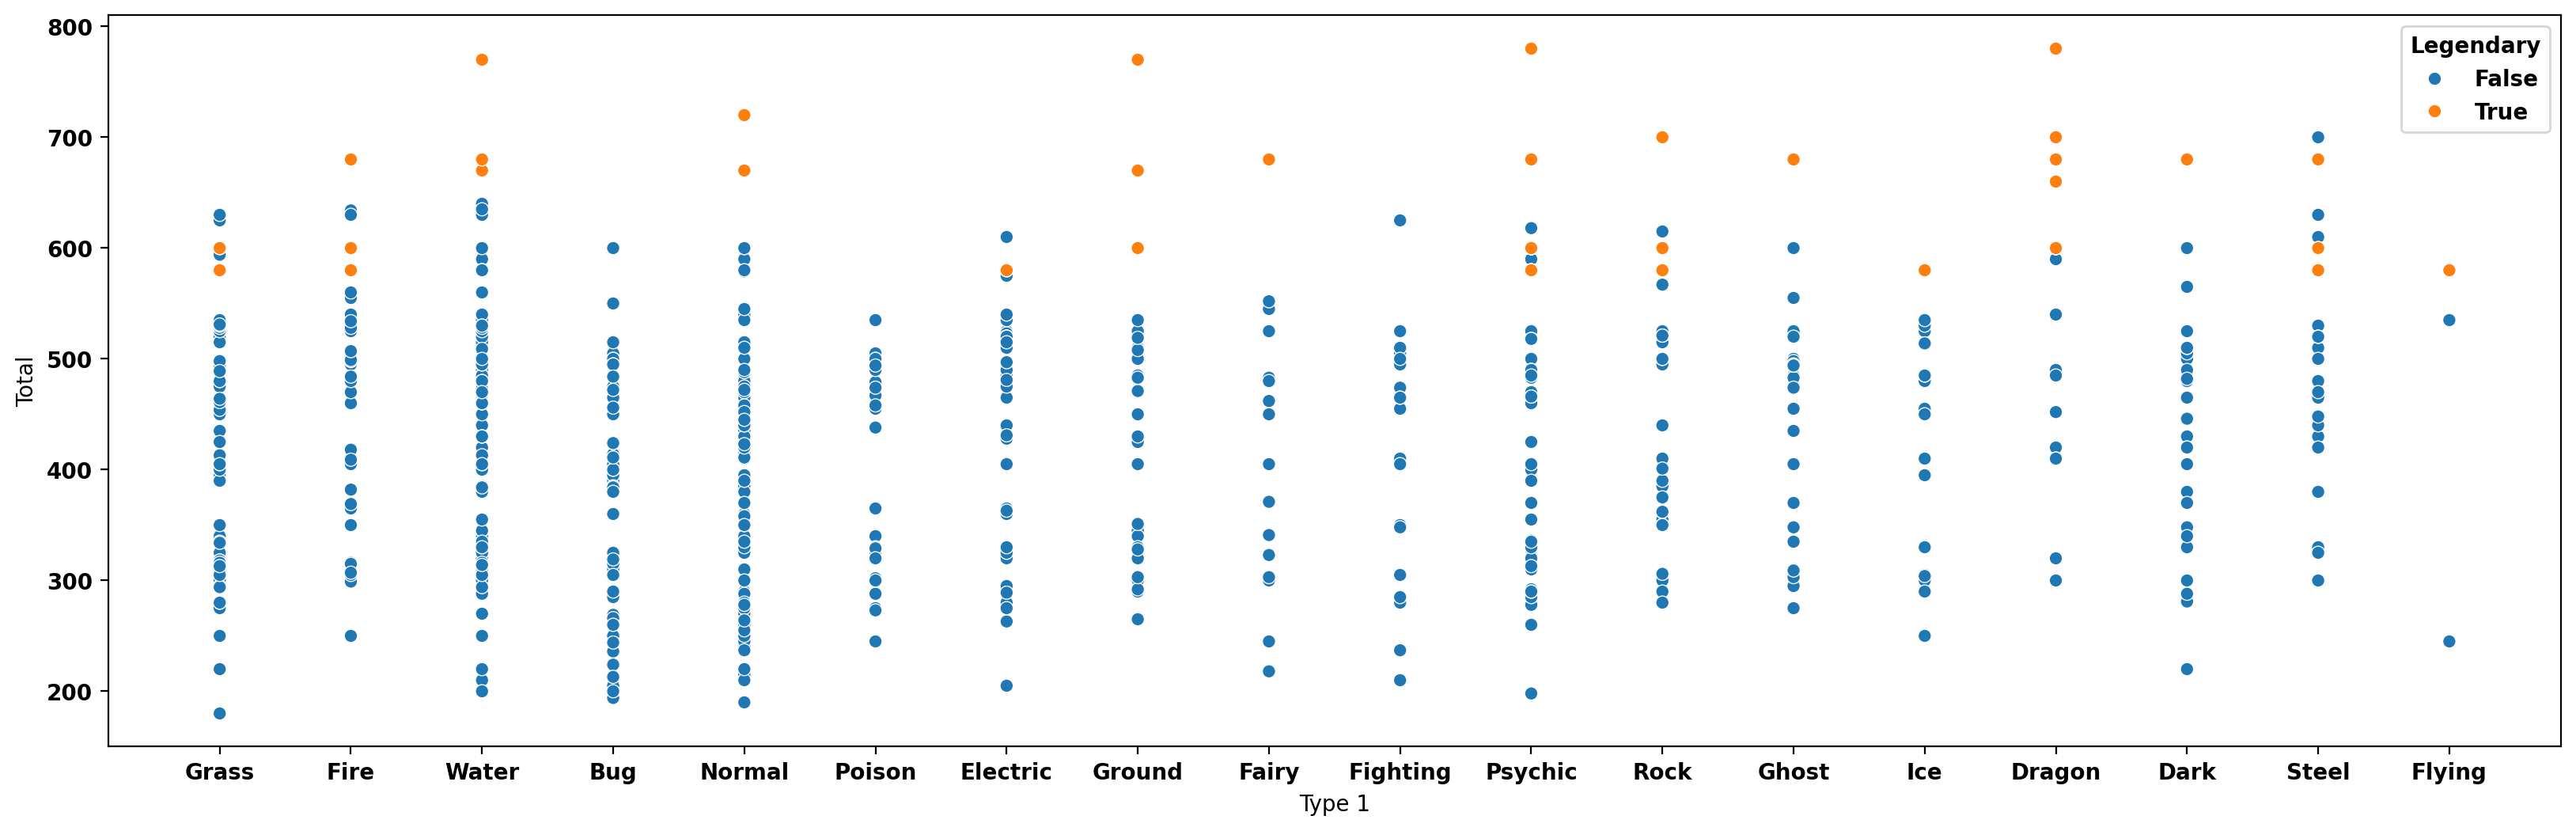

In [252]:
# Total값에 따른 분포 plot
# Total값과 Legendary는 어떤 관계가 있을지 확인
fig, axes = plt.subplots()
fig.set_size_inches(20, 6)

sns.scatterplot(data=pokemon, x="Type 1", y="Total", hue="Legendary")
plt.show()

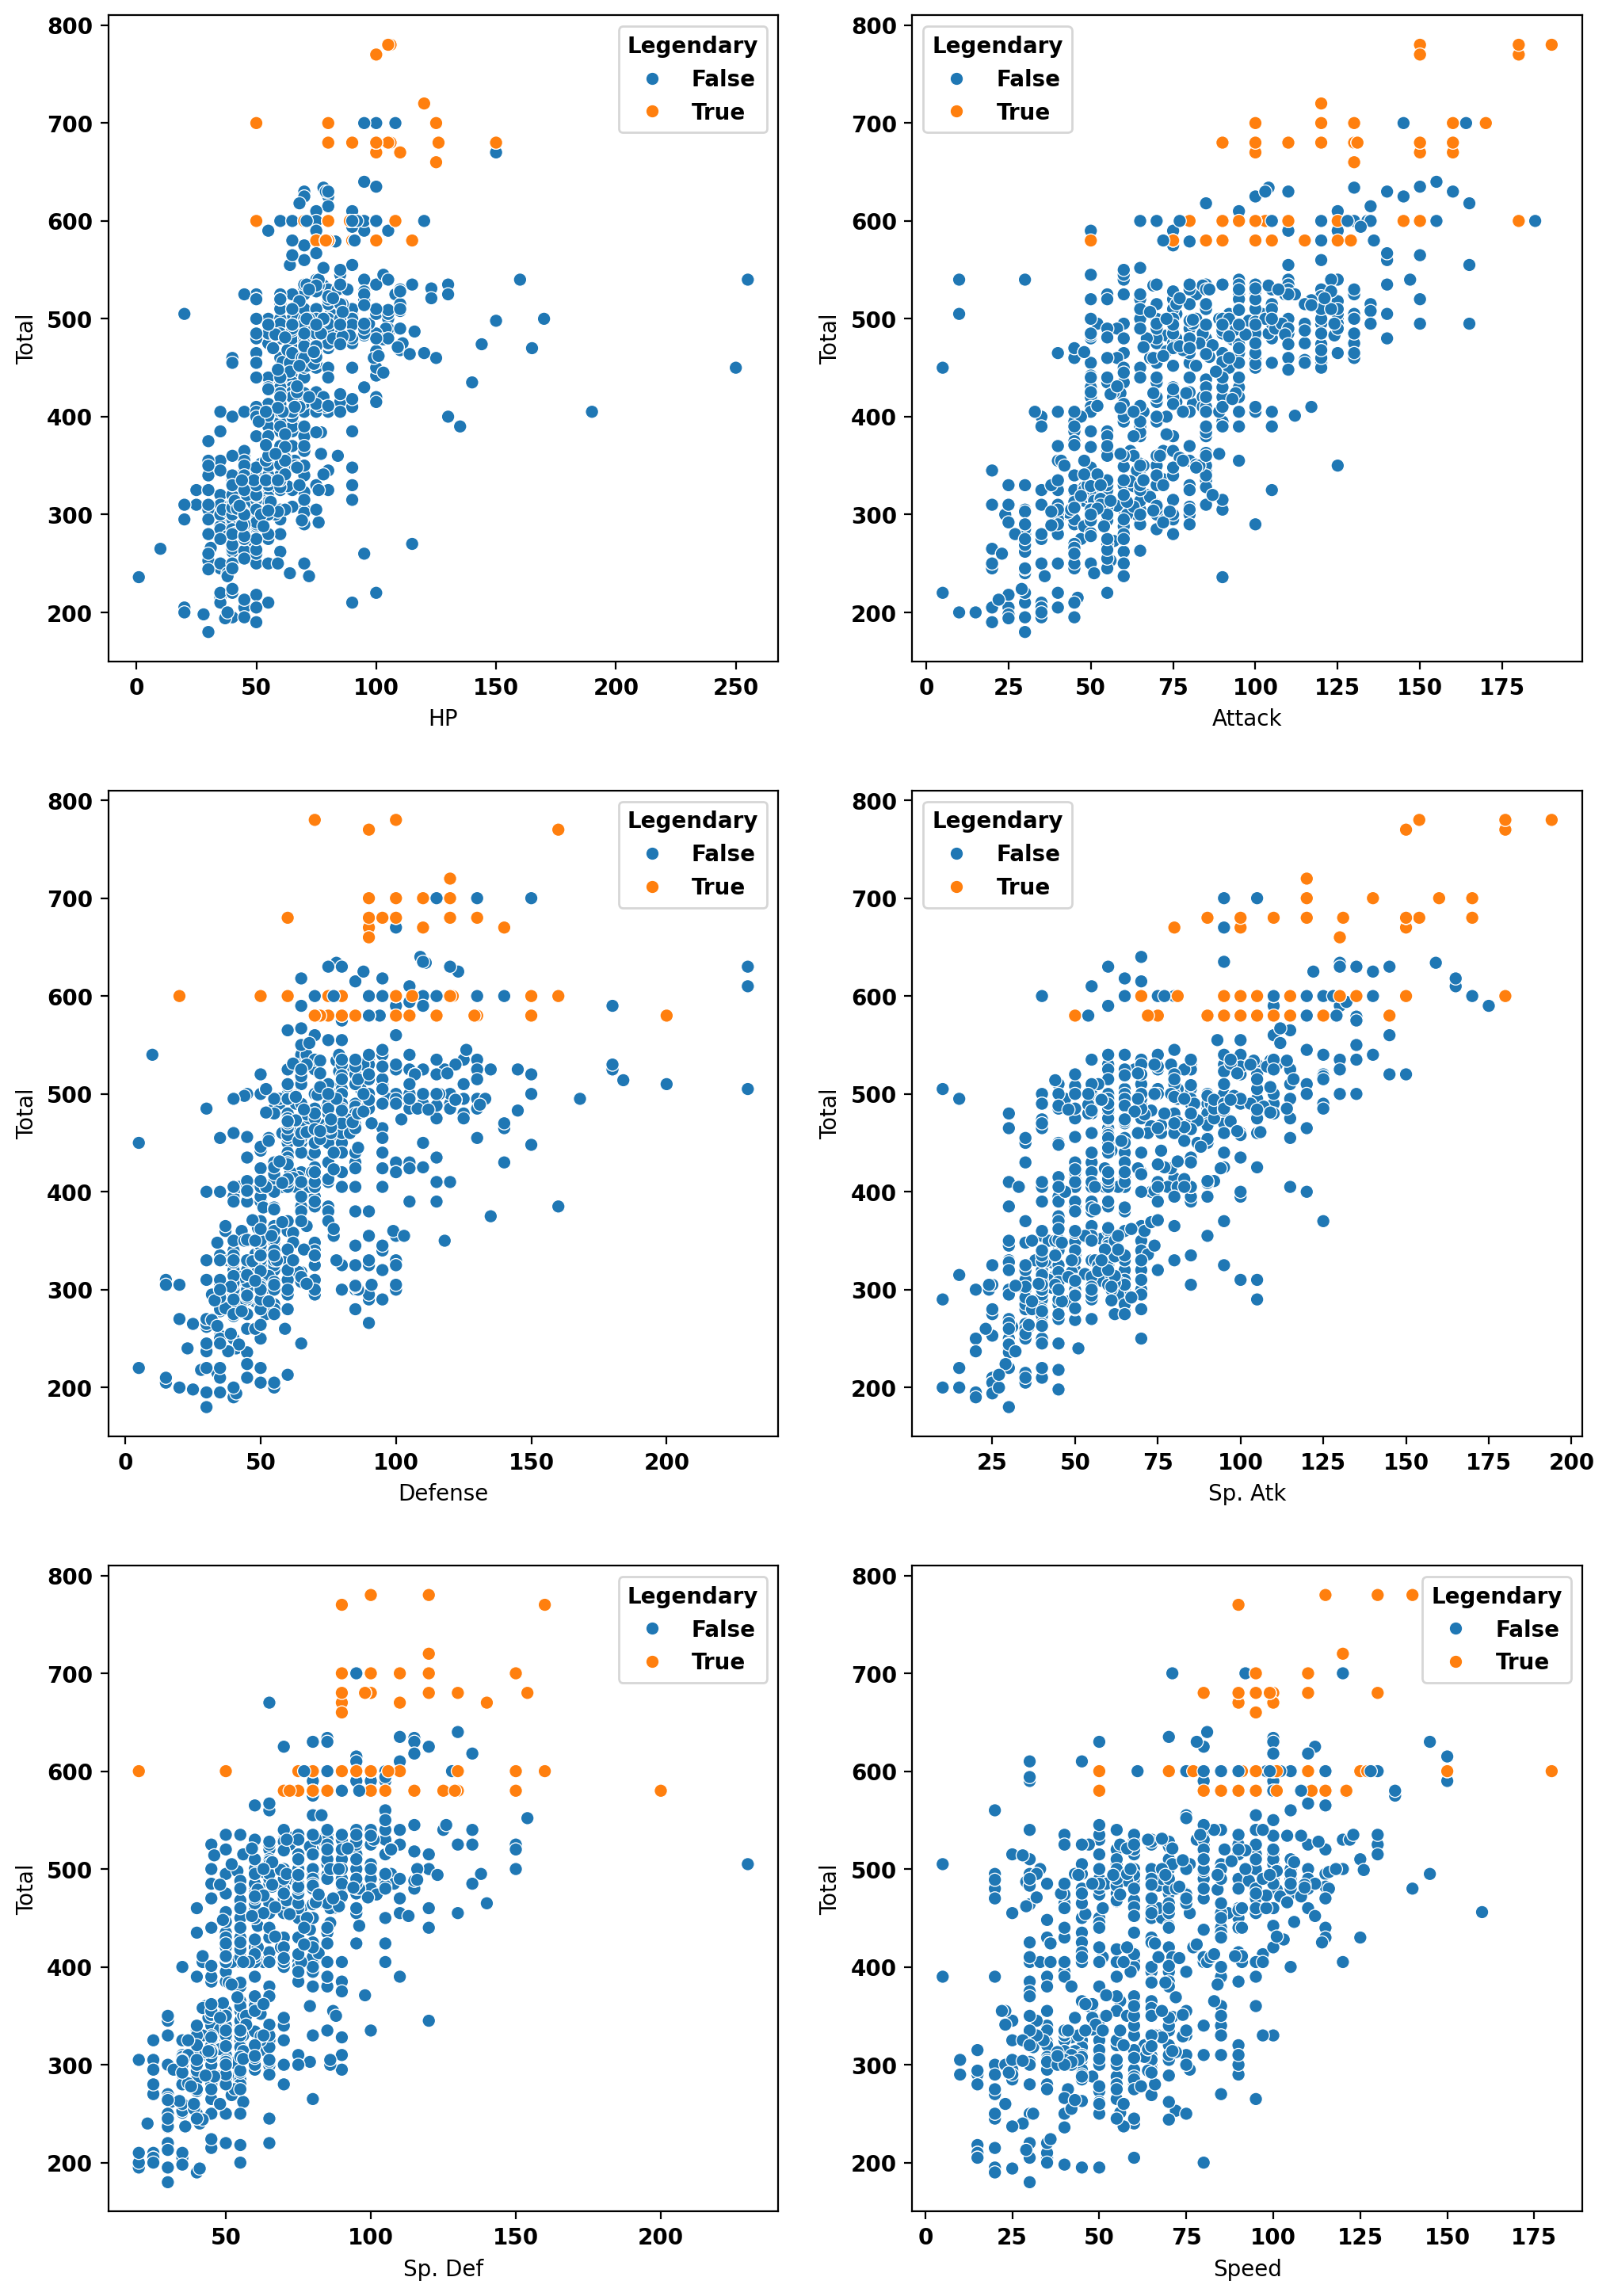

In [253]:
# 세버 스탯
# 긱 스탯에 대한 scatter plot을 6개의 subplot으로 표현
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(12, 18) 


# HP 스탯
sns.scatterplot(data=pokemon, x="HP", y="Total", hue="Legendary", ax=ax1)

# Attack 스탯
sns.scatterplot(data=pokemon, x="Attack", y="Total", hue="Legendary", ax=ax2)

# Defense 스탯
sns.scatterplot(data=pokemon, x="Defense", y="Total", hue="Legendary", ax=ax3)

# Sp.Atk
sns.scatterplot(data=pokemon, x="Sp. Atk", y="Total", hue="Legendary", ax=ax4)

# Sp.Def
sns.scatterplot(data=pokemon, x="Sp. Def", y="Total", hue="Legendary", ax=ax5)

# Speed
sns.scatterplot(data=pokemon, x="Speed", y="Total", hue="Legendary", ax=ax6)
plt.show()

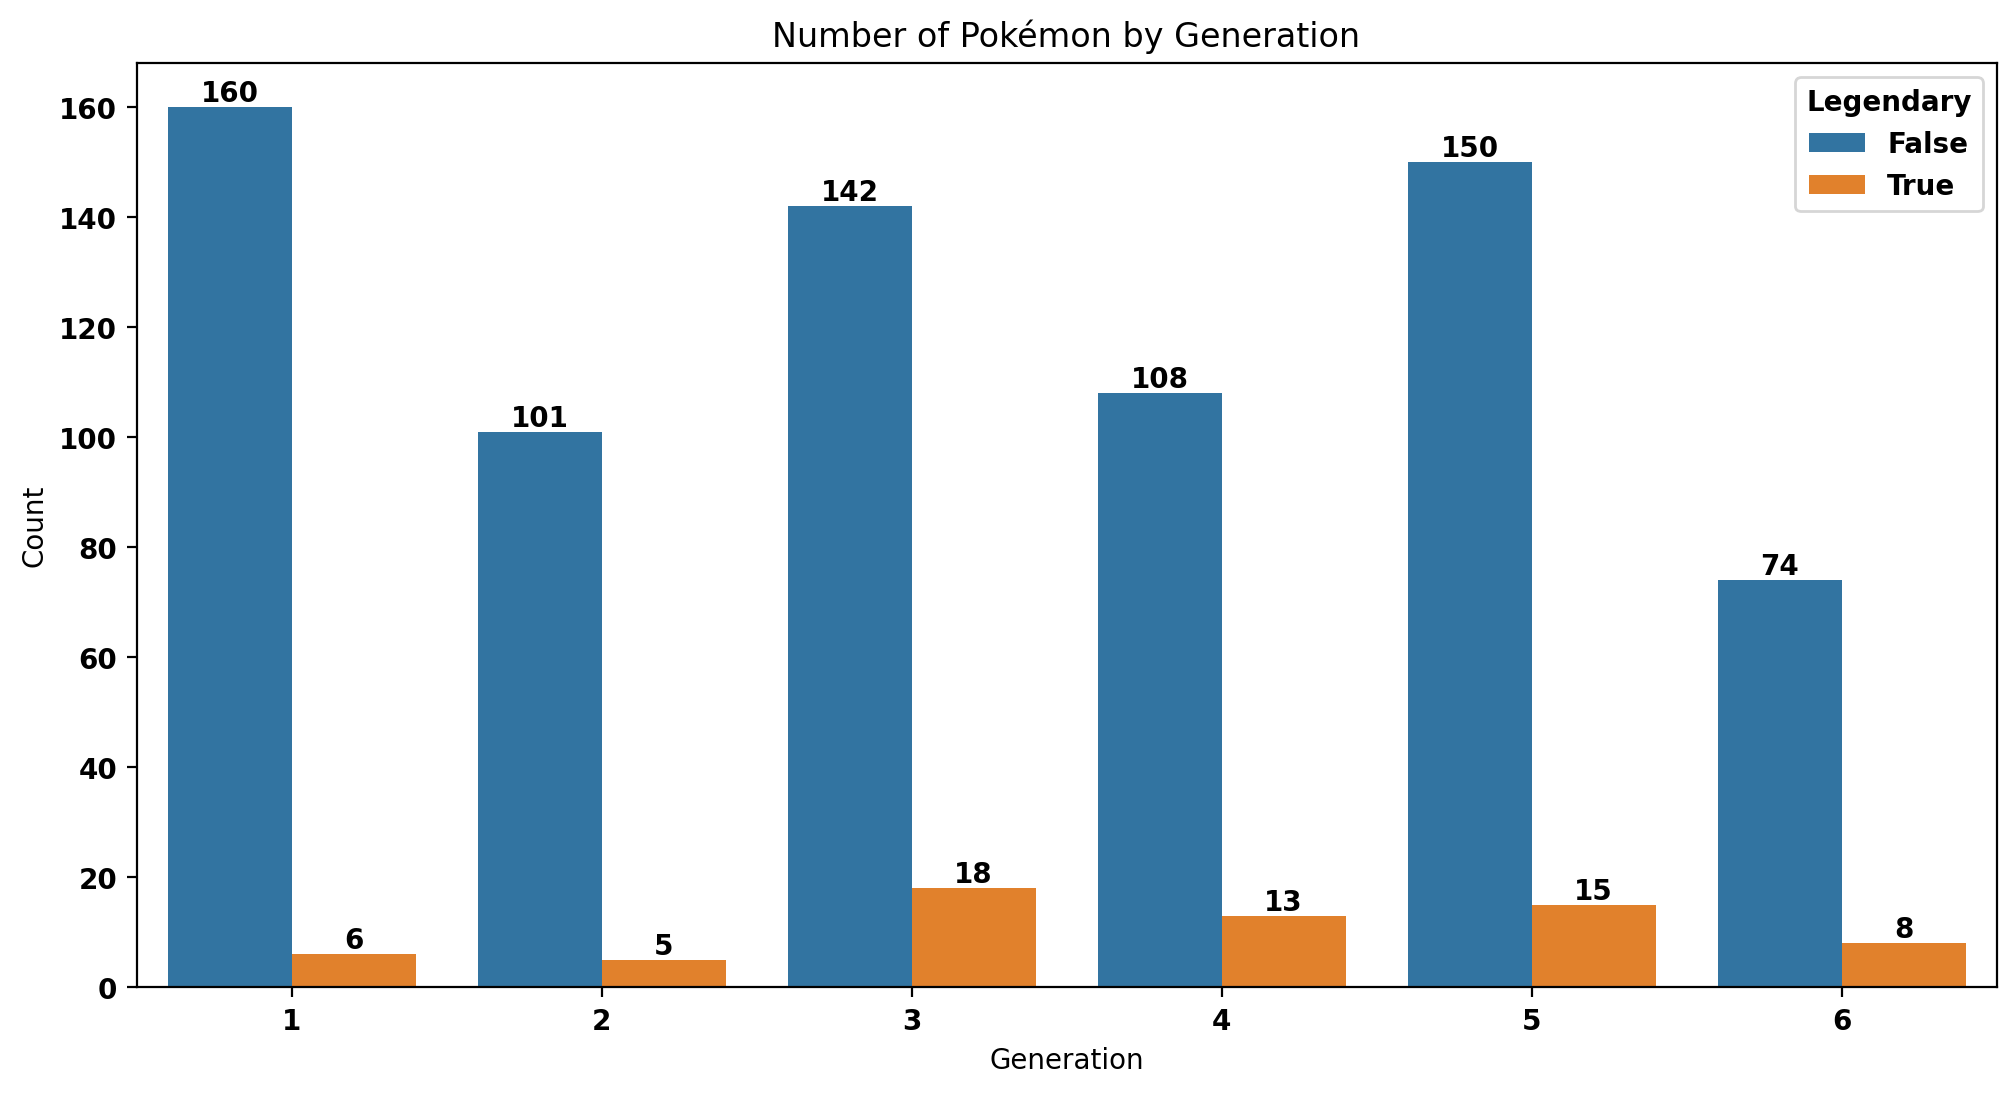

In [254]:
# 각 세대별 포켓몬 수 세기
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 그래프 생성
ax = sns.countplot(data=pokemon, x='Generation', hue='Legendary')

# 막대 위에 데이터 라벨 추가
for container in ax.containers:
    ax.bar_label(container)

plt.title("Number of Pokémon by Generation")
plt.xlabel("Generation")
plt.ylabel("Count")
plt.show()

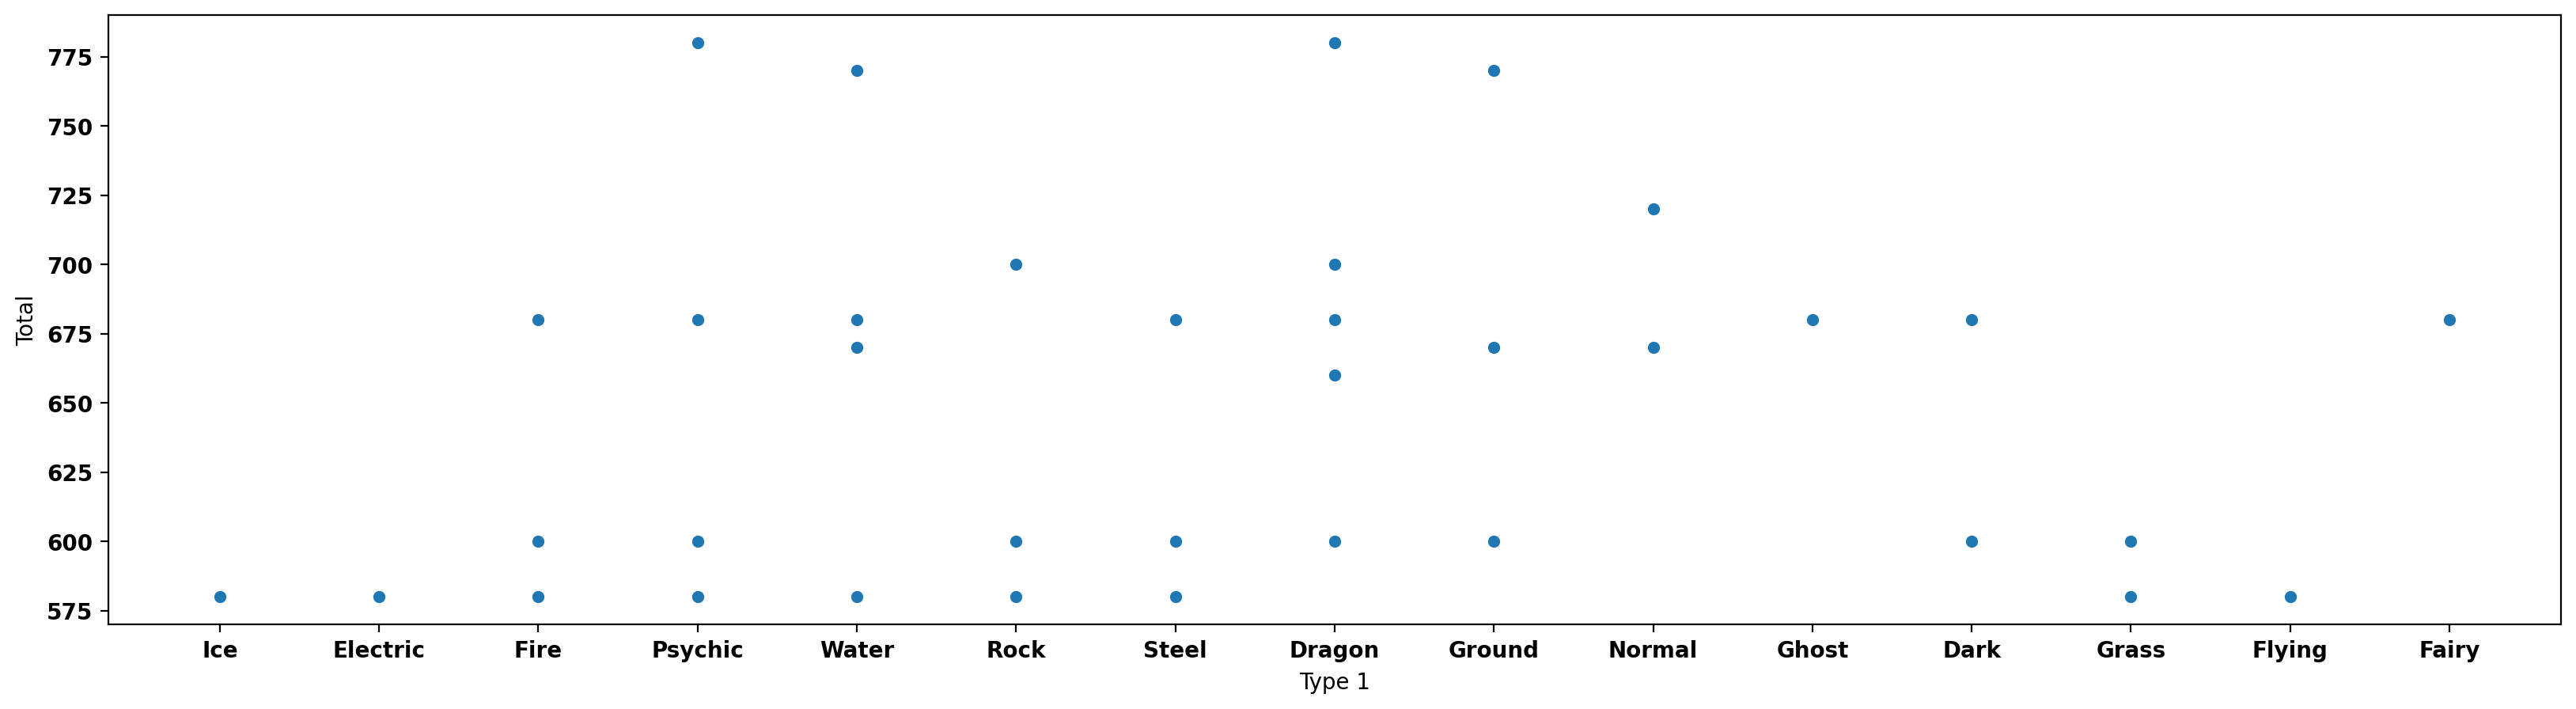

In [255]:
# 전설의 포켓몬 Total 값을 속성(Type 1)별로 확인
fig, ax = plt.subplots()
fig.set_size_inches(20,5)


sns.scatterplot(data=legendary, y="Total", x="Type 1")
plt.show()

In [256]:
# 전설의 포켓몬 Total값의 집합
display(sorted(list(set(legendary["Total"]))))

[580, 600, 660, 670, 680, 700, 720, 770, 780]

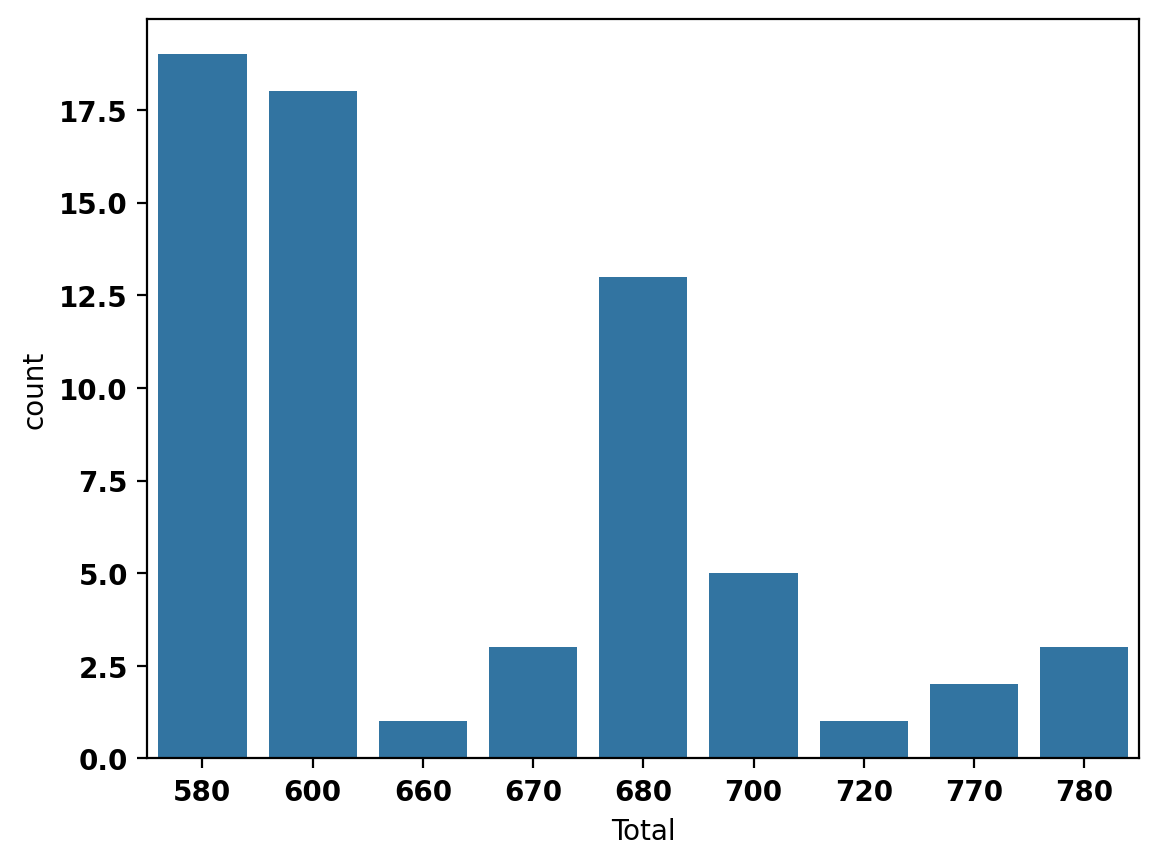

In [257]:
# 전설의 포켓몬이 가지는 각 Totatl값에 대한 포켓몬 수 확인
fig, ax = plt.subplots()
sns.countplot(data=legendary, x="Total")
plt.show()

In [258]:
# 약 7,22마리끼리 같은 Total 스탯 값을 가짐
round(65 / 9, 2)

7.22

In [259]:
# ordinary 포켓몬의 'Total' 값 집합을 확인
display(sorted(list(set(ordinary["Total"]))))

# 이 집합의 크기(길이)를 확인
len(sorted(list(set(ordinary["Total"]))))

# oridinary 몬스터의 평균 Total 스탯 값 구하기
# 약 3.77마리가 같은 Total 스탯 값을 가짐
round(735 / 195, 2)

[180,
 190,
 194,
 195,
 198,
 200,
 205,
 210,
 213,
 215,
 218,
 220,
 224,
 236,
 237,
 240,
 244,
 245,
 250,
 251,
 253,
 255,
 260,
 262,
 263,
 264,
 265,
 266,
 269,
 270,
 273,
 275,
 278,
 280,
 281,
 285,
 288,
 289,
 290,
 292,
 294,
 295,
 299,
 300,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 313,
 314,
 315,
 316,
 318,
 319,
 320,
 323,
 325,
 328,
 329,
 330,
 334,
 335,
 336,
 340,
 341,
 345,
 348,
 349,
 350,
 351,
 352,
 355,
 358,
 360,
 362,
 363,
 365,
 369,
 370,
 371,
 375,
 380,
 382,
 384,
 385,
 390,
 395,
 400,
 401,
 405,
 409,
 410,
 411,
 413,
 414,
 415,
 418,
 420,
 423,
 424,
 425,
 428,
 430,
 431,
 435,
 438,
 440,
 442,
 445,
 446,
 448,
 450,
 452,
 454,
 455,
 456,
 458,
 460,
 461,
 462,
 464,
 465,
 466,
 467,
 468,
 470,
 471,
 472,
 473,
 474,
 475,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 487,
 488,
 489,
 490,
 494,
 495,
 497,
 498,
 499,
 500,
 505,
 507,
 508,
 509,
 510,
 514,
 515,
 518,
 519,
 520,
 521,
 523,
 525,
 528

3.77

In [260]:
# Total값은 legendary인지 아닌지 예측하는데 중요한 칼럼으로 추측
# 이유1 : 전설의 포멧몬의 Total값은 다양하지 않다. 일반 포켓몬의 Total값이 2배 많음.
# 이유2 : 전설의 포켓몬의 Total값 중에는 일반 포켓몬이 가지지 못하는 Total 값이 존재

In [261]:
# 특정 단어가 들어있는 이름 찾기
n1, n2, n3, n4, n5 = legendary[3:6], legendary[14:24], legendary[25:29], legendary[46:50], legendary[52:57]
name = pd.concat([n1, n2, n3, n4, n5]).reset_index(drop=True)
name

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
1,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True
2,150,MewtwoMega Mewtwo Y,Psychic,NaN,780,106,150,70,194,120,140,1,True
3,380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
4,380,LatiasMega Latias,Dragon,Psychic,700,80,100,120,140,150,110,3,True
5,381,Latios,Dragon,Psychic,600,80,90,80,130,110,110,3,True
6,381,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,True
7,382,Kyogre,Water,NaN,670,100,100,90,150,140,90,3,True
8,382,KyogrePrimal Kyogre,Water,NaN,770,100,150,90,180,160,90,3,True
9,383,Groudon,Ground,NaN,670,100,150,140,100,90,90,3,True


In [262]:
# 이름에 formes가 들어있는 전설의 포켓몬 확인
formes = name[13:23]
formes

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
13,386,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,True
14,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
15,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True
16,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True
17,641,TornadusIncarnate Forme,Flying,NaN,580,79,115,70,125,80,111,5,True
18,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True
19,642,ThundurusIncarnate Forme,Electric,Flying,580,79,115,70,125,80,111,5,True
20,642,ThundurusTherian Forme,Electric,Flying,580,79,105,70,145,80,101,5,True
21,645,LandorusIncarnate Forme,Ground,Flying,600,89,125,90,115,80,101,5,True
22,645,LandorusTherian Forme,Ground,Flying,600,89,145,90,105,80,91,5,True


In [263]:
# name count 칼럼 만들기
legendary["name_count"] = legendary["Name"].apply(lambda i: len(i))
legendary

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True,8
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,6
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True,7
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,6
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7
61,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,19
62,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,19
63,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,18


In [264]:
# ordinary 포켓몬의 데이터에도 'name_count' 값을 추가
ordinary["name_count"] = ordinary["Name"].apply(lambda i: len(i))
ordinary

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,711,GourgeistSuper Size,Ghost,Grass,494,85,100,122,58,75,54,6,False,19
731,712,Bergmite,Ice,NaN,304,55,69,85,32,35,28,6,False,8
732,713,Avalugg,Ice,NaN,514,95,117,184,44,46,28,6,False,7
733,714,Noibat,Flying,Dragon,245,40,30,35,45,40,55,6,False,6


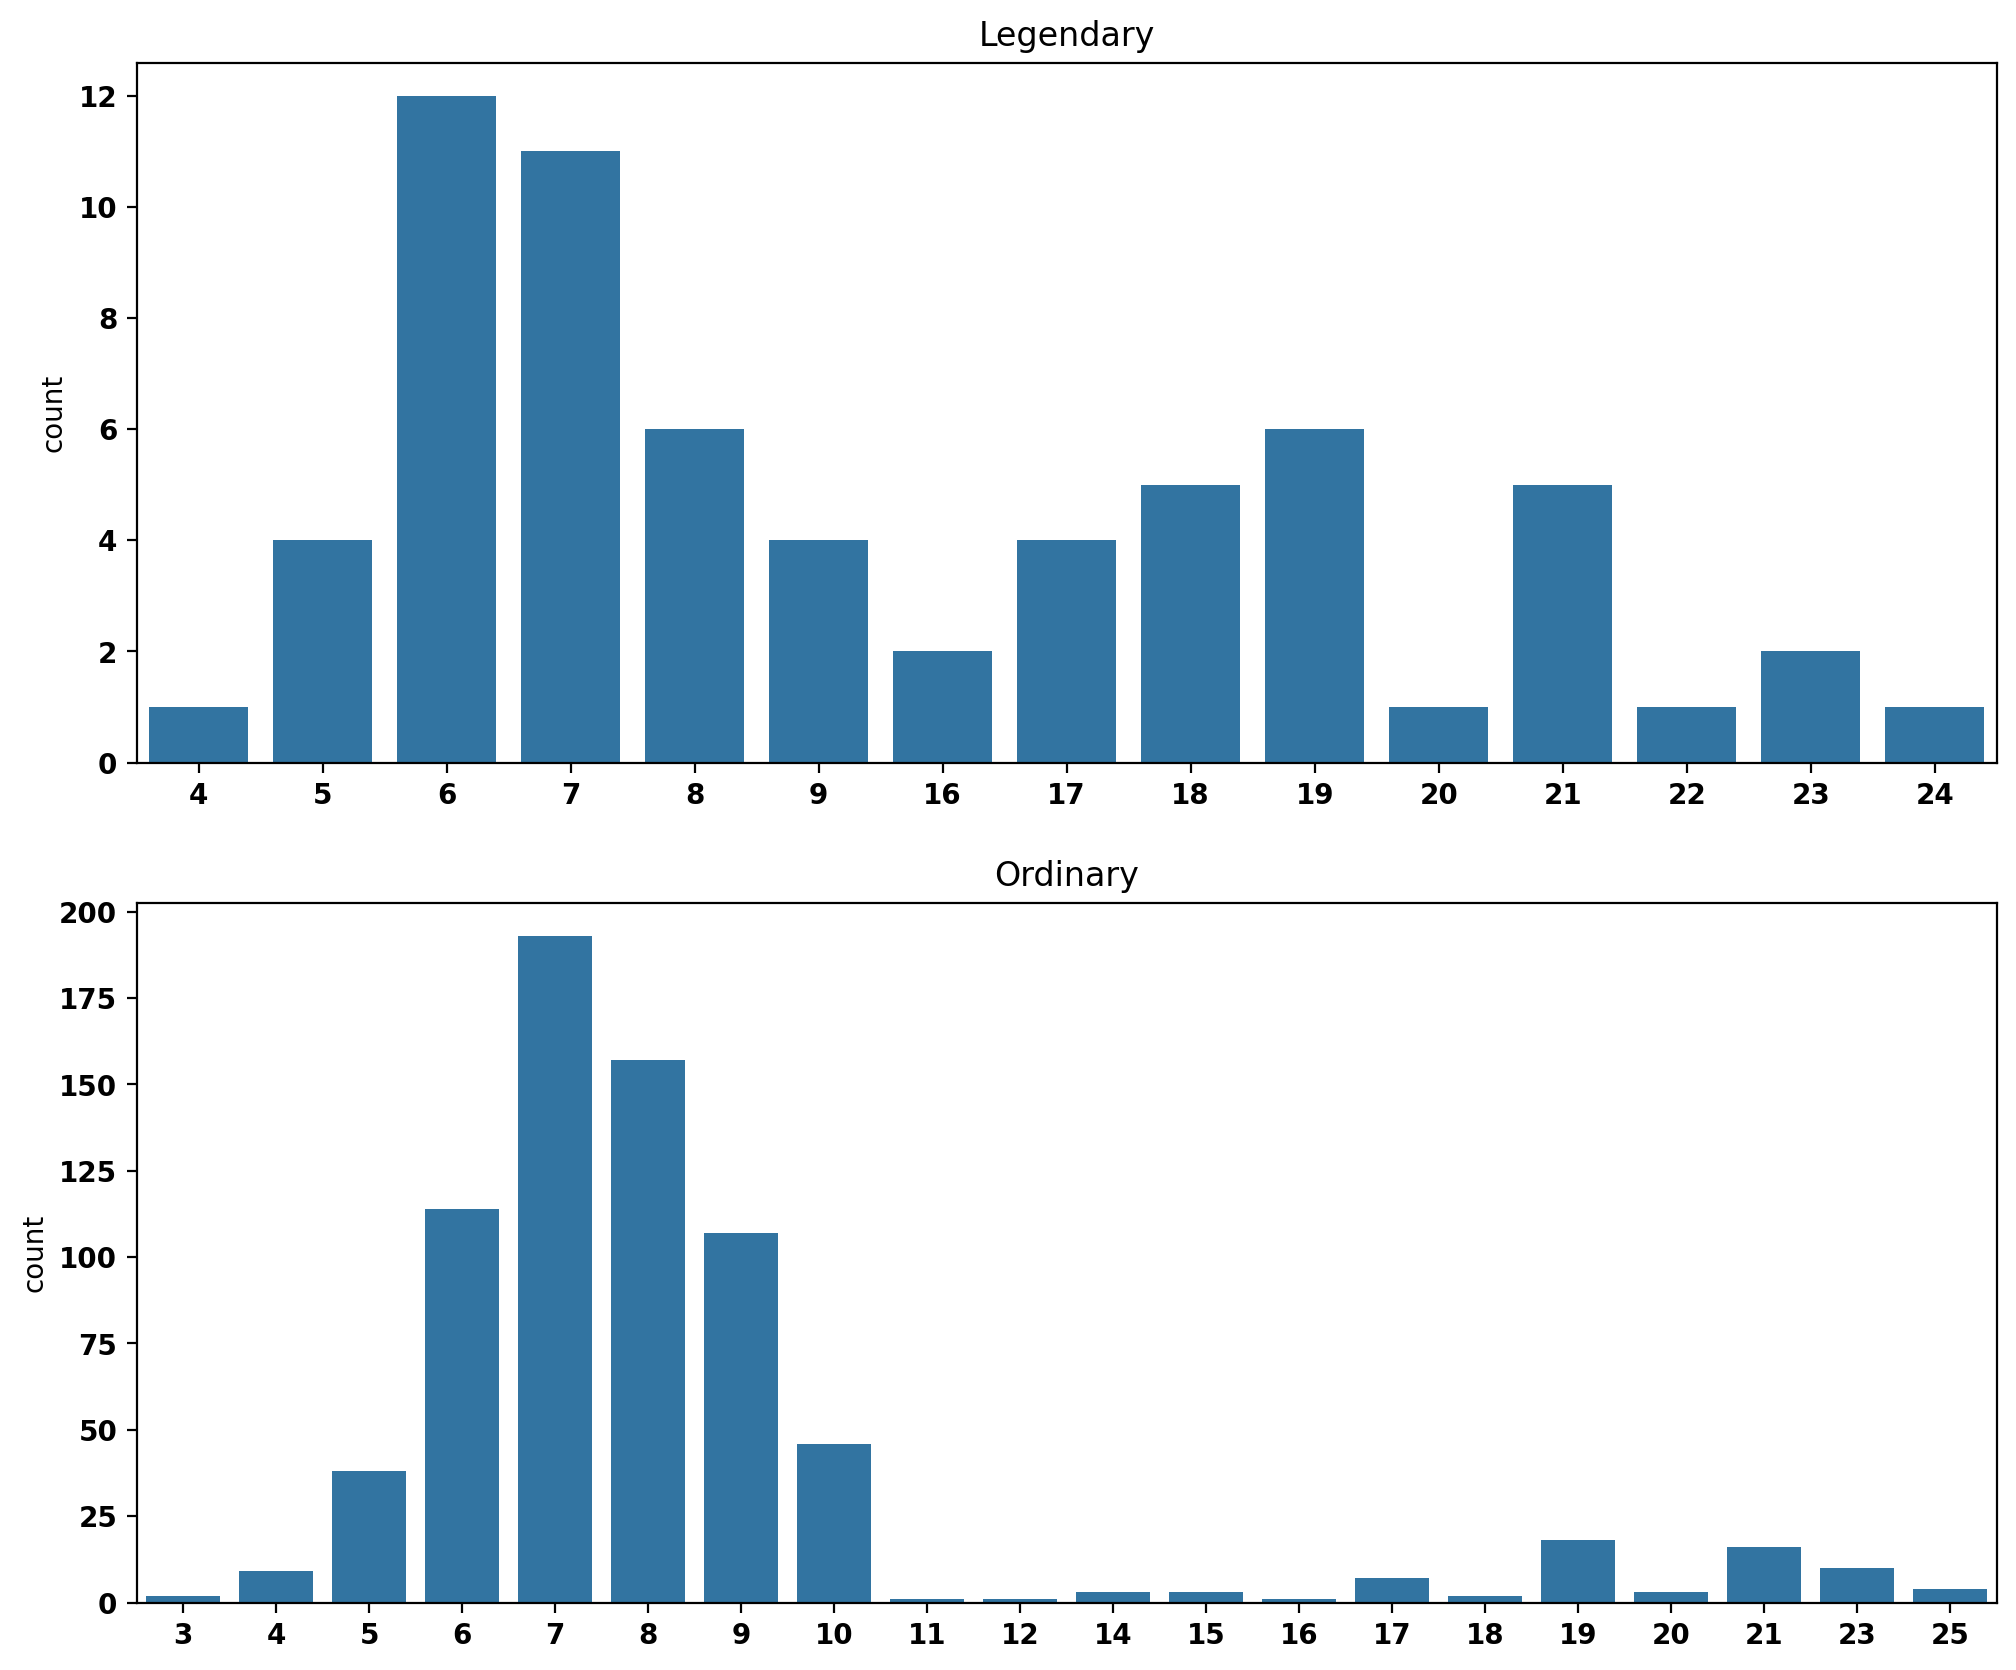

In [265]:
plt.figure(figsize=(12, 10)) 

plt.subplot(211)
sns.countplot(data=legendary, x="name_count").set_xlabel('')
plt.title("Legendary")
plt.subplot(212)
sns.countplot(data=ordinary, x="name_count").set_xlabel('')
plt.title("Ordinary")
plt.show()

# 전설의 포켓몬은 16이상 긴 이름을 가진 포켓몬이 많은 반면 일반 포켓몬은 10이상의 이름을 가지는 빈도가 낮음

In [266]:
# 전설의 포켓몬 이름이 10 이상일 확률
print(round(len(legendary[legendary["name_count"] > 9]) / len(legendary) * 100, 2), "%")
# 일반 포켓몬의 이름이 10 이상일 확률
print(round(len(ordinary[ordinary["name_count"] > 9]) / len(ordinary) * 100, 2), "%")

41.54 %
15.65 %


In [267]:
# "Latios"가 전설의 포켓몬이라면, "%%%Latios" 또한 전설의 포켓몬
# 적어도 전설의 포켓몬에서 높은 빈도를 보이는 이름들의 모임이 존재
# 전설의 포켓몬은 긴 이름을 가진 확률이 높음

In [268]:
# 데이터 전처리 - 이름
# 1. 이름의 길이 : name_count 컬럼을 생성 후 / 길이가 10을 넘는지 아닌지에 대한 categorical 컬럼을 생성
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))
pokemon["long_name"] = pokemon["name_count"] >= 10

In [269]:
# 2. 토큰 추출 : legendary 포켓몬에서 많이 등장하는 토큰을 추려내고 토큰 포함 여부를 원-핫 인코딩(One-Hot Encoding)으로 처리
# 한 단어면 ex. Venusaur
# 두 단어이고, 앞 단어는 두 개의 대문자를 가지며 대문자를 기준으로 두 부분으로 나뉘는 경우 ex. VenusaurMega Venusaur
# 이름은 두 단어이고, 맨 뒤에 X, Y로 성별을 표시하는 경우 ex. CharizardMega Charizard X

# 알파벳이 아닌 문자를 포함하는 경우 ex. Zygarde50% Forme

# 띄어쓰기 없는 알파벳 칼럼 생성
pokemon["no_space_name"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))

# 알파벳 구성 확인
pokemon["Name_is_alpha"] = pokemon["no_space_name"].apply(lambda i: i.isalpha())
# 알파벳이 아닌 다른 구성 확인
pokemon[pokemon["Name_is_alpha"] == False].shape
pokemon[pokemon["Name_is_alpha"] == False]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,stats,name_count,long_name,no_space_name,Name_is_alpha
34,29,Nidoran♀,Poison,NaN,275,55,47,52,40,40,41,1,False,275,8,False,Nidoran♀,False
37,32,Nidoran♂,Poison,NaN,273,46,57,40,40,40,50,1,False,273,8,False,Nidoran♂,False
90,83,Farfetch'd,Normal,Flying,352,52,65,55,58,62,60,1,False,352,10,True,Farfetch'd,False
131,122,Mr. Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,460,8,False,Mr.Mime,False
252,233,Porygon2,Normal,NaN,515,85,80,90,105,95,60,2,False,515,8,False,Porygon2,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,680,5,False,Ho-oh,False
487,439,Mime Jr.,Psychic,Fairy,310,20,25,45,70,90,60,4,False,310,8,False,MimeJr.,False
525,474,Porygon-Z,Normal,NaN,535,85,80,70,135,75,90,4,False,535,9,False,Porygon-Z,False
794,718,Zygarde50% Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,600,16,True,Zygarde50%Forme,False


In [270]:
# 알파벳이 아닌 문자 -> 알파벳으로 변경
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,stats,name_count,long_name,no_space_name,Name_is_alpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,275,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,273,8,False,Nidoran Y,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,352,10,True,Farfetchd,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,460,8,False,Mr.Mime,False
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,515,8,False,Porygon Two,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,680,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,310,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,535,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,600,16,True,Zygarde50%Forme,False


In [271]:
# 바꿔준 'Name' 컬럼으로 'Name_nospace'를 만들고, 다시 isalpha()로 체크
pokemon["no_space_name"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon["Name_is_alpha"] = pokemon["no_space_name"].apply(lambda i: i.isalpha())
pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,stats,name_count,long_name,no_space_name,Name_is_alpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,275,8,False,NidoranX,True
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,273,8,False,NidoranY,True
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,352,10,True,Farfetchd,True
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,460,8,False,MrMime,True
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,515,8,False,PorygonTwo,True
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,680,5,False,HoOh,True
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,310,8,False,MimeJr,True
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,535,9,False,PorygonZ,True
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,600,16,True,ZygardeForme,True


In [272]:
name = "CharizardMega Charizard X"

# 이름을 공백을 기준으로 쪼개기
name_split = name.split(" ")
print(name_split)

# 대문자 기준으로 쪼개기
re.findall('[A-Z][a-z]*', name_split[0])

['CharizardMega', 'Charizard', 'X']


['Charizard', 'Mega']

In [273]:
tokens = []
for temp in name_split:
    a = re.findall('[A-Z][a-z]*', temp)
    tokens.extend(a)
tokens

['Charizard', 'Mega', 'Charizard', 'X']

In [274]:
def tokenize(name):
    name_split = name.split()  # 공백으로 문자열 분리
    tokens = [] # 지역변수 선언

    for temp in name_split:
        a = re.findall('[A-Z][a-z]*', temp)
        tokens.extend(a)

    return np.array(tokens)
    

name = "CharizardMega Charizard X"
tokenize(name)

array(['Charizard', 'Mega', 'Charizard', 'X'], dtype='<U9')

In [275]:
all_tokens = legendary["Name"].apply(tokenize).values

token_list=[]
for token in all_tokens:
    token_list.extend(token)

display(len(set(token_list)))
display(print(token_list))


65

[np.str_('Articuno'), np.str_('Zapdos'), np.str_('Moltres'), np.str_('Mewtwo'), np.str_('Mewtwo'), np.str_('Mega'), np.str_('Mewtwo'), np.str_('X'), np.str_('Mewtwo'), np.str_('Mega'), np.str_('Mewtwo'), np.str_('Y'), np.str_('Raikou'), np.str_('Entei'), np.str_('Suicune'), np.str_('Lugia'), np.str_('Ho'), np.str_('Regirock'), np.str_('Regice'), np.str_('Registeel'), np.str_('Latias'), np.str_('Latias'), np.str_('Mega'), np.str_('Latias'), np.str_('Latios'), np.str_('Latios'), np.str_('Mega'), np.str_('Latios'), np.str_('Kyogre'), np.str_('Kyogre'), np.str_('Primal'), np.str_('Kyogre'), np.str_('Groudon'), np.str_('Groudon'), np.str_('Primal'), np.str_('Groudon'), np.str_('Rayquaza'), np.str_('Rayquaza'), np.str_('Mega'), np.str_('Rayquaza'), np.str_('Jirachi'), np.str_('Deoxys'), np.str_('Normal'), np.str_('Forme'), np.str_('Deoxys'), np.str_('Attack'), np.str_('Forme'), np.str_('Deoxys'), np.str_('Defense'), np.str_('Forme'), np.str_('Deoxys'), np.str_('Speed'), np.str_('Forme'), np.

None

In [276]:
a = [1, 1, 0, 0, 0, 1, 1, 2, 3]
Counter(a)

Counter({1: 4, 0: 3, 2: 1, 3: 1})

In [277]:
Counter(a).most_common()

[(1, 4), (0, 3), (2, 1), (3, 1)]

In [278]:
most_common = Counter(token_list).most_common(10)
most_common

[(np.str_('Forme'), 15),
 (np.str_('Mega'), 6),
 (np.str_('Mewtwo'), 5),
 (np.str_('Kyurem'), 5),
 (np.str_('Deoxys'), 4),
 (np.str_('Hoopa'), 4),
 (np.str_('Latias'), 3),
 (np.str_('Latios'), 3),
 (np.str_('Kyogre'), 3),
 (np.str_('Groudon'), 3)]

In [279]:
for token, _ in most_common:
    # print(token)
    # pokemon[token] = ... 형식으로 사용하면 뒤에서 warning이 발생합니다
    pokemon[f"{token}"] = pokemon["Name"].str.contains(token)

pokemon

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Forme,Mega,Mewtwo,Kyurem,Deoxys,Hoopa,Latias,Latios,Kyogre,Groudon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,False,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,False,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,False,False,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,False,True,False,False,False,False,False,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,...,False,False,False,False,False,False,False,False,False,False
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,...,False,True,False,False,False,False,False,False,False,False
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,...,False,False,False,False,False,True,False,False,False,False
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,...,False,False,False,False,False,True,False,False,False,False


In [280]:
# 범주형 데이터 처리 - Type
# 18가지 Type -> onehot encoding
# 두 가지 속성을 가진 포켓몬 두 가지 타입에 -> 1

In [281]:
types = list(set(pokemon["Type 1"]))
print(types)

['Fire', 'Normal', 'Fairy', 'Fighting', 'Dragon', 'Flying', 'Ground', 'Ghost', 'Grass', 'Ice', 'Electric', 'Steel', 'Dark', 'Bug', 'Water', 'Psychic', 'Poison', 'Rock']


In [282]:
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t)

(pokemon[["Type 1", "Type 2"] + types].head(20))

,Type 1,Type 2,Fire,Normal,Fairy,Fighting,Dragon,Flying,Ground,Ghost,Grass,Ice,Electric,Steel,Dark,Bug,Water,Psychic,Poison,Rock
0,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
2,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
3,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
4,Fire,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,Fire,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,Fire,Flying,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7,Fire,Dragon,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
8,Fire,Flying,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
9,Water,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [283]:
# [0]를 사용한 버전
display(pokemon[[["Type 1", "Type 2"] + types][0]].head())

# [0]를 제거한 더 간단한 버전
display(pokemon[["Type 1", "Type 2"] + types].head())

,Type 1,Type 2,Fire,Normal,Fairy,Fighting,Dragon,Flying,Ground,Ghost,Grass,Ice,Electric,Steel,Dark,Bug,Water,Psychic,Poison,Rock
0,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
2,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
3,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
4,Fire,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


,Type 1,Type 2,Fire,Normal,Fairy,Fighting,Dragon,Flying,Ground,Ghost,Grass,Ice,Electric,Steel,Dark,Bug,Water,Psychic,Poison,Rock
0,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
2,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
3,Grass,Poison,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
4,Fire,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [284]:
# 베이스 라인 모델 학습 - 오리지날 데이터 출력
display(original_data.shape)
original_data.head()

(800, 13)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [285]:
# numeric feature만 list화
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
features


['Total',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation']

In [286]:
target = 'Legendary'

In [287]:
# 각 feature가 실제로 데이터프레임에 있는지 확인

# numeric feature만 list화
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
features

for feature in features:
    if feature not in original_data.columns:
        print(f"'{feature}' 컬럼이 데이터프레임에 없습니다!")


In [288]:
# Q. 'original_data'에서 'features' 컬럼에 해당하는 데이터를 변수 'X'에 저장
X = original_data[features]
print(X.shape)
print(X.head())

(800, 8)
   Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation
0    318  45      49       49       65       65     45           1
1    405  60      62       63       80       80     60           1
2    525  80      82       83      100      100     80           1
3    625  80     100      123      122      120     80           1
4    309  39      52       43       60       50     65           1


In [289]:
# Q. 'target' 컬럼의 데이터를 변수 'y'에 저장
y = original_data[[target]]
print(y.shape)
y.head()


(800, 1)


,Legendary
0,False
1,False
2,False
3,False
4,False


In [290]:
# 머신러닝 train, test 데이터셋 분리

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 8) (640, 1)
(160, 8) (160, 1)


In [291]:
model = DecisionTreeClassifier(random_state=25)
model

DecisionTreeClassifier(random_state=25)

In [292]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [293]:
confusion_matrix(y_test, y_pred)

array([[144,   3],
       [  5,   8]])

In [294]:
len(legendary)

65

In [295]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



In [296]:
print(len(pokemon.columns))

46


In [297]:
display(len(pokemon.columns))
display(pokemon.columns)

46

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'stats',
       'name_count', 'long_name', 'no_space_name', 'Name_is_alpha', 'Forme',
       'Mega', 'Mewtwo', 'Kyurem', 'Deoxys', 'Hoopa', 'Latias', 'Latios',
       'Kyogre', 'Groudon', 'Fire', 'Normal', 'Fairy', 'Fighting', 'Dragon',
       'Flying', 'Ground', 'Ghost', 'Grass', 'Ice', 'Electric', 'Steel',
       'Dark', 'Bug', 'Water', 'Psychic', 'Poison', 'Rock'],
      dtype='object')

In [1]:
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 
            'name_count','long_name', 'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']

len(features)

38

In [2]:
target = "Legendary"
target

'Legendary'

In [ ]:
# Q. 사용할 feature에 해당하는 데이터를 'X' 변수에 저장
